STAT 453: Deep Learning (Spring 2020)    
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/   
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

---

Ritikkumar Goyal
ragoyal2@wisc.edu

In [6]:
import torch
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# No need to change anything here!
# If there is a GPU available, it will use it,
# otherwise, it will use the CPU

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Loading the Dataset

The dataset consists of 10 classes similar to the original MNIST dataset. Also, it shares the same overall structure with MNIST, i.e., there are 60k training images and 10k test images, and all images are black & white images of size 28x28. 

Below is an example of how the images look like:

![](figures/fashion-mnist-sprite.png)

(Image Source: https://github.com/zalandoresearch/fashion-mnist)



The 10 classes in this dataset are


| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Before you continue, please execute the companion notebook "Notebook for Preparing the Dataset for HW3" ([`hw3-dataprep.ipynb`](hw3-dataprep.ipynb)) for downloading and preparing the dataset.

---

## Dataset Loader

In [152]:
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

import os


# class FashionMNISTDataset(Dataset):
#     """Custom Dataset for loading FashionMNIST images"""

#     def __init__(self, csv_path):
#         df = pd.read_csv(csv_path)
#         self.img_dir = img_dir
#         self.img_names = df['image_name'].values
#         self.y = df['class_label'].values
#         self.transform = transform

#     def __getitem__(self, index):
#         img = Image.open(os.path.join(self.img_dir,
#                                       self.img_names[index]))
        
#         if self.transform is not None:
#             img = self.transform(img)
        
#         label = self.y[index]
#         return img, label

#     def __len__(self):
#         return self.y.shape[0]
    
class StockDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)[0:1000]
#         self.y = 100*((df['Target'].to_numpy().astype('float32') / df['Stock Price'].to_numpy().astype('float32')) - 1)
        self.y = df['Label'].to_numpy().astype('float32')
        self.features = df.drop(["Company", "Date", "Target", "Label"], axis=1).to_numpy().astype('float32')

    def __getitem__(self, index):
        features = self.features[index]
        label = self.y[index]
        
        return features, label

    def __len__(self):
        return self.y.shape[0]

In [153]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

BATCH_SIZE = 64

In [154]:
train_dataset = StockDataset(csv_path='train_raw.csv')


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)


valid_dataset = StockDataset(csv_path='val_raw.csv')

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

test_dataset = StockDataset(csv_path='test_raw.csv')

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=0)

The cell below just checks if the dataset can be loaded correctly.

In [155]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        display(x)
        display(y)
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 64


tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.5601e-01,
          2.0000e+00,  2.0001e+00],
        [ 2.3606e+08, -6.8669e-01,  5.5899e+07,  ...,  1.2693e-01,
          2.7610e+01,  2.8863e+01],
        [ 8.1570e+09, -4.4736e-02,  1.5450e+09,  ..., -3.1968e-02,
          8.2200e+00,  8.8406e+00],
        ...,
        [ 1.3804e+07,  1.0000e+00,  8.0160e+06,  ...,  1.8480e-01,
          9.2600e+00,  9.8709e+00],
        [ 1.0377e+07,  1.2953e-02,  8.6582e+06,  ..., -1.3073e-01,
          3.4500e+00,  3.6882e+00],
        [ 3.3802e+08,  3.8812e-02,  2.8956e+08,  ..., -1.5701e-02,
          9.2400e+00,  1.2038e+01]])

tensor([8., 3., 0., 1., 3., 0., 2., 5., 1., 5., 6., 4., 4., 3., 0., 8., 2., 1.,
        1., 4., 2., 7., 3., 4., 8., 7., 6., 1., 8., 6., 1., 3., 2., 8., 5., 2.,
        6., 7., 4., 4., 0., 2., 3., 5., 6., 1., 5., 3., 6., 0., 2., 1., 8., 7.,
        3., 5., 3., 7., 5., 6., 7., 0., 2., 5.])

break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 64


tensor([[ 1.8803e+10, -2.7672e+00,  0.0000e+00,  ...,  0.0000e+00,
          3.1250e+01,  3.3071e+01],
        [ 1.9880e+07,  3.8941e-01,  0.0000e+00,  ..., -5.7223e-01,
          3.1900e+00,  3.6149e+00],
        [ 2.3950e+09,  1.3542e-02,  1.9880e+09,  ...,  9.5023e-02,
          2.0580e+01,  2.2332e+01],
        ...,
        [ 3.5170e+06,  1.2574e+00,  2.3360e+06,  ...,  0.0000e+00,
          1.0600e+00,  0.0000e+00],
        [ 1.0711e+09, -1.1028e-01,  6.1719e+08,  ..., -3.3579e-02,
          5.1400e+01,  5.3680e+01],
        [ 5.5365e+08, -7.2477e-03,  2.8683e+08,  ...,  1.2746e-01,
          2.2790e+01,  2.4587e+01]])

tensor([7., 5., 7., 1., 3., 4., 8., 8., 5., 6., 2., 1., 7., 5., 2., 8., 4., 1.,
        5., 3., 8., 7., 7., 1., 7., 0., 3., 4., 2., 0., 3., 1., 7., 7., 5., 5.,
        6., 8., 5., 5., 7., 6., 2., 0., 7., 0., 3., 0., 8., 2., 8., 4., 6., 7.,
        3., 3., 2., 5., 0., 6., 1., 1., 2., 1.])

break minibatch for-loop


If you get an error, make sure the `png-files` folder is unzipped and it the same directory as this notebook!

# Multilayer Perceptron Model

The cell below contains the multi-layer perceptron model. This is the main section where you want to make changes to the architecture.

In [156]:
num_features = 143

In [157]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################


class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_hidden_3, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        
        ### ADD ADDITIONAL LAYERS BELOW IF YOU LIKE
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_1_bn = torch.nn.BatchNorm1d(num_hidden_1)

        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_2_bn = torch.nn.BatchNorm1d(num_hidden_2)

        self.linear_3 = torch.nn.Linear(num_hidden_2, num_hidden_3)
        self.linear_3_bn = torch.nn.BatchNorm1d(num_hidden_3)

        self.linear_out = torch.nn.Linear(num_hidden_3, num_classes)
        
    def forward(self, x):
        
        ### MAKE SURE YOU CONNECT THE LAYERS PROPERLY IF YOU CHANGED
        ### ANYTHNG IN THE __init__ METHOD ABOVE       
        out = self.linear_1(x)
#         out = self.linear_1_bn(out)
        out = torch.sigmoid(out)
        out = F.dropout(out, p=0.5, training=self.training)
        
#         out = self.linear_2(out)
#         out = self.linear_2_bn(out)
#         out = torch.relu(out)
#         out = F.dropout(out, p=0.5, training=self.training)
        
#         out = self.linear_3(out)
#         out = self.linear_3_bn(out)
#         out = torch.relu(out)
#         out = F.dropout(out, p=0.5, training=self.training)

        logits = self.linear_out(out)
        probas = torch.sigmoid(logits)
        return logits, probas
        
        
#################################
### Model Initialization
#################################


# the random seed makes sure that the random weight initialization
# in the model is always the same.
# In practice, some weights don't work well, and we may also want
# to try different random seeds. In this homework, this is not
# necessary.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### IF YOU CHANGED THE ARCHITECTURE ABOVE, MAKE SURE YOU 
### ACCOUNT FOR IT VIA THE PARAMETERS BELOW. I.e., if you
### added a second hidden layer, you may want to add a
### hidden_2 parameter here. Also you may want to play
### with the number of hidden units.
model = MLP(num_features=143,
            num_hidden_1=100,
            num_hidden_2=100,
            num_hidden_3=100,
            num_classes=1)

model = model.to(DEVICE)

In [193]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

### For this homework, do not change the optimizer. However, you
### likely want to experiment with the learning rate!
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
###########################################################

In [194]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

NUM_EPOCHS = 1000 # Please feel free to change
############################################################

In [195]:
def compute_mse(net, data_loader):
    curr_mse, num_examples = torch.zeros(model.num_classes).float(), 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, num_features).to(DEVICE)
            targets = targets.view(-1, 1)
            logits, probas = net.forward(features.float())
            probas = probas.to(torch.device('cpu'))
            loss = torch.sum((targets - probas)**2, dim=0)
            num_examples += targets.size(0)
            curr_mse += loss

        curr_mse = torch.mean(curr_mse/num_examples, dim=0)
        return curr_mse

def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, num_features).to(DEVICE)
        targets = targets.view(-1, 1).to(DEVICE)
        
        ### FORWARD AND BACK PROP
        logits, probas = model(features.float())
#         print("Logits")
#         print(logits)
#         print("Probas")
#         print(probas)
        cost = F.mse_loss(targets, logits)
#         print(cost)
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 200:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_loss = compute_mse(model, train_loader)
        valid_loss = compute_mse(model, valid_loader)
#         train_acc_lst.append(train_acc)
#         valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Loss.: {train_loss:.2f}'
              f' | Validation Loss.: {valid_loss:.2f}')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/1000 | Batch 000/016 | Cost: 6.4526
Epoch: 001/1000 Train Loss.: 15.55 | Validation Loss.: 16.41
Time elapsed: 0.00 min
Epoch: 002/1000 | Batch 000/016 | Cost: 6.1526
Epoch: 002/1000 Train Loss.: 15.55 | Validation Loss.: 16.41
Time elapsed: 0.00 min
Epoch: 003/1000 | Batch 000/016 | Cost: 6.6207
Epoch: 003/1000 Train Loss.: 15.55 | Validation Loss.: 16.41
Time elapsed: 0.00 min
Epoch: 004/1000 | Batch 000/016 | Cost: 6.9216
Epoch: 004/1000 Train Loss.: 15.55 | Validation Loss.: 16.41
Time elapsed: 0.00 min
Epoch: 005/1000 | Batch 000/016 | Cost: 7.1703
Epoch: 005/1000 Train Loss.: 15.55 | Validation Loss.: 16.41
Time elapsed: 0.00 min
Epoch: 006/1000 | Batch 000/016 | Cost: 6.9044
Epoch: 006/1000 Train Loss.: 15.55 | Validation Loss.: 16.41
Time elapsed: 0.00 min
Epoch: 007/1000 | Batch 000/016 | Cost: 7.5263
Epoch: 007/1000 Train Loss.: 15.55 | Validation Loss.: 16.41
Time elapsed: 0.01 min
Epoch: 008/1000 | Batch 000/016 | Cost: 5.1537
Epoch: 008/1000 Train Loss.: 15.55 |

KeyboardInterrupt: 

# Evaluation (No Need To Change Any Code in This Section!)

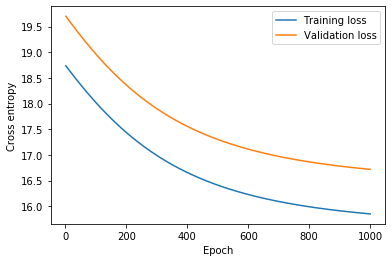

In [165]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (0,)

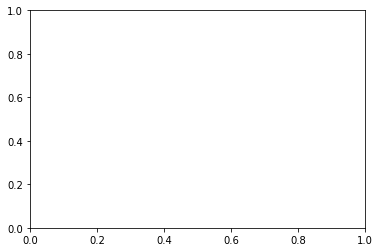

In [166]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [167]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

RuntimeError: shape '[-1, 784]' is invalid for input of size 9152

In [196]:
num = 0

model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    for i, (x, y) in enumerate(test_loader):
        if i == num:
            logits, probas = model(x)
            pred = np.argmax(probas, axis=1)
            print(logits.view(1,-1))
            print(y)
#             print(y[4].item() == np.argmax(probas, axis=1)[4].item())

tensor([[3.5908, 4.4296, 3.9549, 3.7788, 3.4959, 4.5799, 4.3617, 3.6985, 3.8059,
         3.8352, 3.9735, 3.8603, 4.0253, 3.6682, 3.7194, 4.0383, 4.3566, 4.0029,
         3.7414, 4.1916, 3.9318, 3.9776, 4.5796, 3.9426, 3.9024, 3.7849, 3.5381,
         4.2494, 3.8268, 3.9785, 3.6572, 4.1440, 3.9138, 3.9181, 3.9783, 4.3566,
         4.0373, 3.7403, 3.9140, 3.7997, 3.9013, 3.6901, 3.7277, 3.7763, 3.6799,
         3.7964, 3.6726, 4.0521, 3.8022, 3.9083, 4.1519, 4.0526, 3.5831, 3.8200,
         4.4837, 4.1841, 4.5327, 4.2134, 3.9183, 3.8317, 4.0665, 4.1985, 4.1133,
         3.4241]])
tensor([0., 8., 1., 4., 1., 2., 0., 7., 3., 0., 5., 1., 3., 0., 0., 3., 2., 4.,
        8., 1., 7., 6., 1., 1., 5., 8., 1., 8., 5., 6., 7., 2., 1., 0., 2., 7.,
        3., 0., 6., 6., 2., 4., 0., 8., 0., 7., 0., 1., 2., 2., 4., 4., 3., 2.,
        4., 7., 0., 4., 8., 8., 1., 4., 5., 2.])
